In [1]:
import csv
import importlib
import itertools
import math
import os
import pathlib
import time
import urllib.request
import warnings
from ast import In
from collections import defaultdict
from dataclasses import dataclass
from tabnanny import check

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm


In [2]:
# CONSTANT
RANDOM_STATE = 0
BUFFER_SIZE = 8500
BATCH_SIZE = 64
NUM_CLASS = 10
MIN_TIME = 200

IMG_PATH = "./data/oregon_wildlife"
INPUT_DIR = "./input"
CHECKPOINT_DIR = "./checkpoint"

IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

# Set random seed
tf.random.set_seed(RANDOM_STATE)

# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

# Create directory
if not os.path.exists(INPUT_DIR):
    os.makedirs(INPUT_DIR)

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Download lib
if not os.path.exists("lib/lab11_1_lib.py"):
    urllib.request.urlretrieve(
        "https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py",
        "src/lab11_1_lib.py",
    )

lab11_1_lib = importlib.import_module("lib.lab11_1_lib")
draw_timeline = lab11_1_lib.draw_timeline


In [3]:
def load_data():
    img_dir = pathlib.Path(IMG_PATH)

    # Get paths of all images
    all_image_paths = list(img_dir.glob("*/*"))
    all_image_paths = [str(path) for path in all_image_paths]
    all_image_paths = shuffle(all_image_paths, random_state=RANDOM_STATE)
    all_image_paths = [
        path for path in all_image_paths if path[-3:] not in ("gif", "bmp")
    ]

    # Get class name of labels
    img_labels = sorted(item.name for item in img_dir.glob("*") if item.is_dir())

    # Build mapping from label class to label index and reverse
    label_to_index = {class_name: index for index, class_name in enumerate(img_labels)}
    index_to_label = {index: class_name for index, class_name in enumerate(img_labels)}

    # Get all image labels
    all_image_labels = [
        label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths
    ]

    # Get total number of images
    image_count = len(all_image_paths)
    print(f"Totol number of images: {image_count}")

    # Get number of classes
    class_count = len(img_labels)
    print(f"Totol number of classes: {class_count}")
    print(f"Labels: {img_labels}")
    print(f"Mappings: {label_to_index}")

    @dataclass
    class LabelIndexMapping:
        label_to_index: dict
        index_to_label: dict

    return list(zip(all_image_paths, all_image_labels)), LabelIndexMapping(
        label_to_index, index_to_label
    )


def make_train_test_csv(input_pairs, test_size=0.2):
    # Split image paths to train and test image paths
    train_pairs, test_pairs = train_test_split(
        input_pairs, test_size=test_size, random_state=RANDOM_STATE
    )

    # Create train csv
    with open(os.path.join(INPUT_DIR, "train.csv"), "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["img_path", "label"])
        for img_path, img_label in train_pairs:
            writer.writerow([img_path, img_label])

    # Create test csv
    with open(os.path.join(INPUT_DIR, "test.csv"), "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["img_path", "label"])
        for img_path, img_label in test_pairs:
            writer.writerow([img_path, img_label])

    return len(train_pairs), len(test_pairs)


In [4]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE = (
        # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        # counters: [
        # (instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)
        # ]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300, 300, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )

    # Number of datasets generated
    _INSTANCES_COUNTER = itertools.count()
    # Number of epochs done for each dataset
    _EPOCHS_COUNTER = defaultdict(itertools.count)

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, img_label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter

        # Reading the file
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                img_label[sample_idx],
            )
            open_enter, open_elapsed = -1.0, -1.0  # Negative values will be filtered

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename),
        )


In [5]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows["img_path"].tolist()
    img_label = rows["label"].tolist()
    return img_paths, img_label


def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    return img


def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset(
        os.path.join(INPUT_DIR, "train.csv"), open_file, read_file
    )


def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset(
        os.path.join(INPUT_DIR, "test.csv"), open_file, read_file
    )


In [6]:
# Change the input to specific format
input_pairs, label_index_mapping = load_data()
train_size, test_size = make_train_test_csv(input_pairs)

# Make train and test dataset
dataset_train = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_train)
    .batch(BATCH_SIZE, drop_remainder=True)
)
dataset_test = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_test)
    .batch(BATCH_SIZE, drop_remainder=True)
)


Totol number of images: 7168
Totol number of classes: 10
Labels: ['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']
Mappings: {'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation="relu"))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation="relu"))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(NUM_CLASS, activation="softmax"))

wild_model = tf.keras.Model(
    inputs=base_model.input, outputs=top_model(base_model.output)
)

wild_model.save_weights(os.path.join(CHECKPOINT_DIR, "wild_model.h5"))
wild_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")


In [9]:
@tf.function
def train_step(image, img_label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(img_label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(img_label, predictions)


@tf.function
def test_step(image, img_label):
    predictions = wild_model(image, training=False)
    loss = loss_object(img_label, predictions)

    test_loss(loss)
    test_accuracy(img_label, predictions)


In [10]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, img_label in tqdm(
            dataset_train, total=math.floor(train_size / BATCH_SIZE)
        ):
            time.sleep(0.05)

            steps_acc = tf.concat(
                [steps_acc, tf.reshape(steps, (steps.shape[0] * steps.shape[1], 1))],
                axis=0,
            )
            times_acc = tf.concat(
                [times_acc, tf.reshape(times, (times.shape[0] * times.shape[1], 2))],
                axis=0,
            )
            values_acc = tf.concat(
                [
                    values_acc,
                    tf.reshape(values, (values.shape[0] * values.shape[1], 3)),
                ],
                axis=0,
            )

            # record training time
            train_enter = time.perf_counter()
            train_step(image, img_label)
            train_elapsed = time.perf_counter() - train_enter

            time.sleep(0.05)

            train_time = tf.concat(
                [
                    tf.fill([times.shape[0], 1], train_enter),
                    tf.fill([times.shape[0], 1], train_elapsed),
                ],
                axis=1,
            )  # shape=(times.shape[0], 2)
            steps_acc = tf.concat(
                [steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0
            )
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:, -1, :]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, img_label in tqdm(
            dataset_test, total=math.floor(test_size / BATCH_SIZE)
        ):
            time.sleep(0.05)

            steps_acc = tf.concat(
                [steps_acc, tf.reshape(steps, (steps.shape[0] * steps.shape[1], 1))],
                axis=0,
            )
            times_acc = tf.concat(
                [times_acc, tf.reshape(times, (times.shape[0] * times.shape[1], 2))],
                axis=0,
            )
            values_acc = tf.concat(
                [
                    values_acc,
                    tf.reshape(values, (values.shape[0] * values.shape[1], 3)),
                ],
                axis=0,
            )

            test_enter = time.perf_counter()
            test_step(image, img_label)
            test_elapsed = time.perf_counter() - test_enter

            time.sleep(0.05)

            test_time = tf.concat(
                [
                    tf.fill([times.shape[0], 1], test_enter),
                    tf.fill([times.shape[0], 1], test_elapsed),
                ],
                axis=1,
            )  # shape=(times.shape[0], 2)
            steps_acc = tf.concat(
                [steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0
            )
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:, -1, :]], axis=0)

        template = "Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}"
        tf.print(
            template.format(
                epoch + 1,
                train_loss.result(),
                train_accuracy.result() * 100,
                test_loss.result(),
                test_accuracy.result() * 100,
            )
        )

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}


In [11]:
def check_image(dataset_train):
    for steps, timings, counters, img, label in dataset_train.take(1):
        print(steps[0], timings[0], counters[0])
        print(img[0].shape)
        plt.imshow(img[0])
        plt.axis("off")
        plt.show()
        print(label_index_mapping.index_to_label[label[0].numpy()])


In [12]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)


start time:  1382161.03295206
training:


100%|██████████| 89/89 [10:56<00:00,  7.38s/it]

testing:



100%|██████████| 22/22 [02:42<00:00,  7.41s/it]

Epoch 1, Loss: 5.1406, Accuracy: 25.1580, test Loss: 1.2351, test Accuracy: 64.7017
training:



100%|██████████| 89/89 [08:52<00:00,  5.99s/it]

testing:



100%|██████████| 22/22 [02:13<00:00,  6.05s/it]

Epoch 2, Loss: 1.1552, Accuracy: 59.3399, test Loss: 0.6971, test Accuracy: 81.3210
training:



100%|██████████| 89/89 [08:49<00:00,  5.95s/it]

testing:



100%|██████████| 22/22 [02:15<00:00,  6.14s/it]

Epoch 3, Loss: 0.7888, Accuracy: 73.5955, test Loss: 0.5609, test Accuracy: 82.7415
Execution time: 2150.560877881944


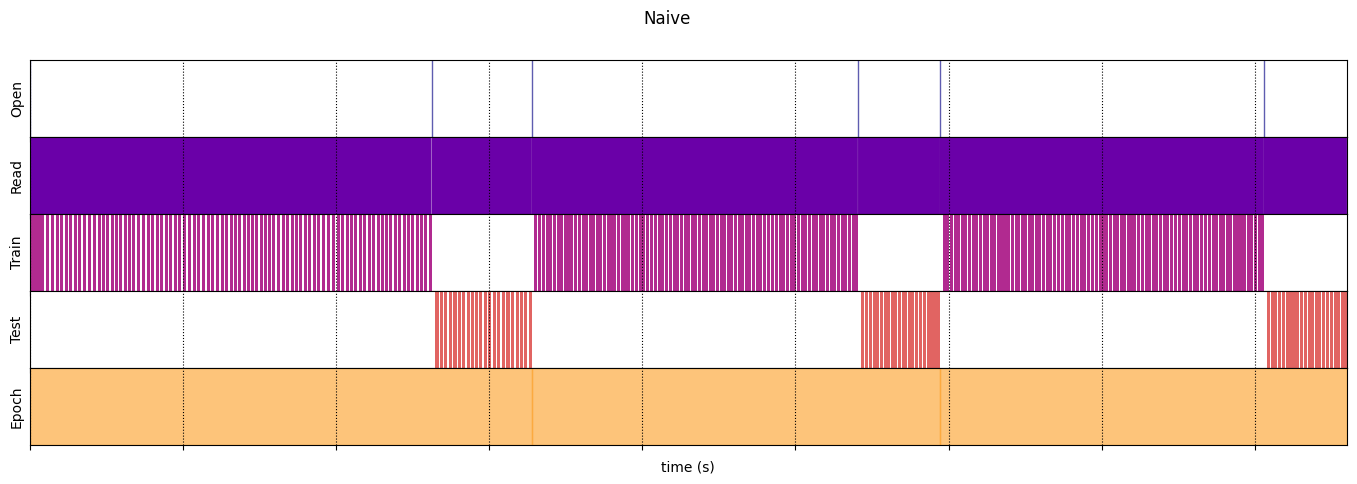

In [14]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=250)


In [15]:
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32),
        )

    return wrapper


@map_decorator
def map_train_with_transformation(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    # record the enter time
    map_enter = time.perf_counter()

    # Cast label to float32
    label = tf.cast(label, tf.float32)

    # Distort image and standardize image
    distorted_image = tf.image.random_crop(
        image, [IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH]
    )
    distorted_image = tf.image.per_image_standardization(distorted_image)

    # Transpose and resize image to fit the model
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])

    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0),
        distorted_image,
        label,
    )


@map_decorator
def map_test_with_transformation(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    # Record the enter time
    map_enter = time.perf_counter()

    # Cast label to float32
    label = tf.cast(label, tf.float32)

    # Distort image and standardize image
    distorted_image = tf.image.resize_with_crop_or_pad(
        image, IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED
    )
    distorted_image = tf.image.per_image_standardization(distorted_image)

    # Transpose and resize image to fit the model
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])

    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0),
        distorted_image,
        label,
    )


In [16]:
dataset_train_with_transformation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_train)
    .map(map_train_with_transformation)
    .batch(BATCH_SIZE, drop_remainder=True)
)

dataset_test_with_transformation = (
    tf.data.Dataset.range(1)
    .flat_map(dataset_generator_fun_test)
    .map(map_test_with_transformation)
    .batch(BATCH_SIZE, drop_remainder=True)
)


In [17]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights(os.path.join(CHECKPOINT_DIR, "wild_model.h5"))
timeline_Augmentation = timelined_benchmark(
    dataset_train_with_transformation, dataset_test_with_transformation, EPOCHS=3
)


start time:  1386904.203730301
training:


 22%|██▏       | 20/89 [03:02<10:30,  9.13s/it]


KeyboardInterrupt: 

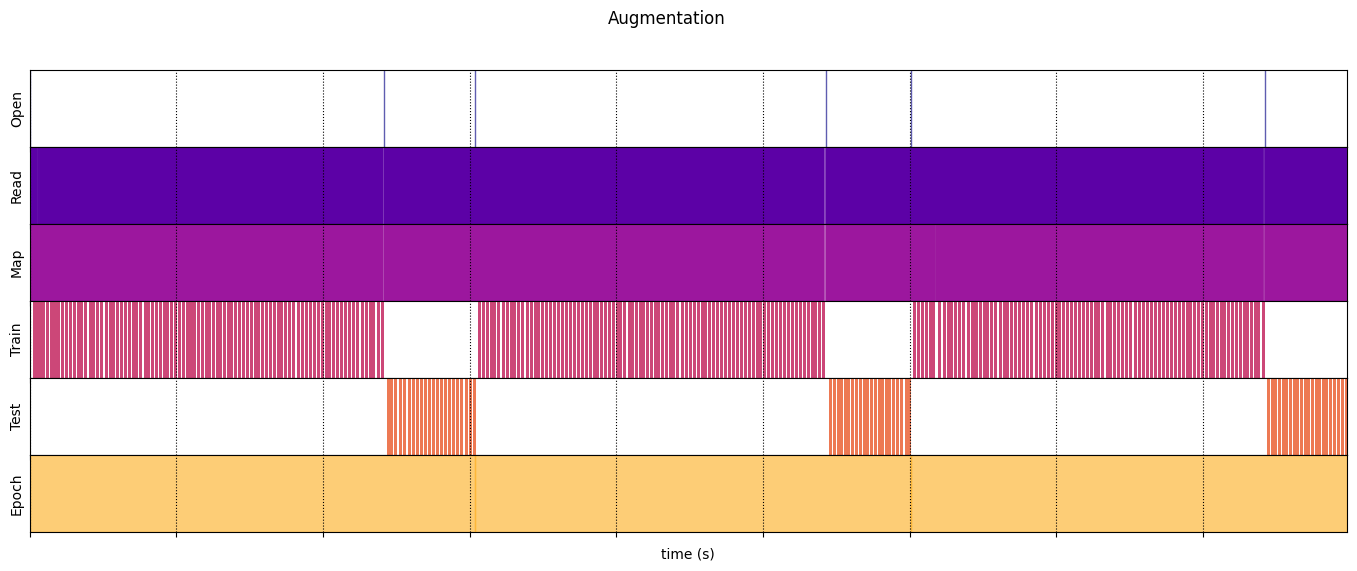

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=500)


In [ ]:
@map_decorator
def map_train_with_transformation_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue

    # record the enter time
    map_enter = time.perf_counter()

    # Cast label to float32
    label = tf.cast(label, tf.float32)

    # Distort image and standardize image
    distorted_image = tf.image.random_crop(
        image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED, IMAGE_DEPTH]
    )
    distorted_image = tf.image.per_image_standardization(distorted_image)

    # Transpose and resize image to fit the model
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])

    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),
        tf.concat(
            (times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1
        ),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),
        distorted_image,
        label,
    )


@map_decorator
def map_test_with_transformation_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue

    # record the enter time
    map_enter = time.perf_counter()

    # Cast label to float32
    label = tf.cast(label, tf.float32)

    # Distort image and standardize image
    distorted_image = tf.image.resize_with_crop_or_pad(
        image, IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED
    )
    distorted_image = tf.image.per_image_standardization(distorted_image)

    # Transpose and resize image to fit the model
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])

    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),
        tf.concat(
            (times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1
        ),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),
        distorted_image,
        label,
    )


In [ ]:
dataset_train_with_optimization = (
    tf.data.Dataset.range(1)
    .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(map_train_with_transformation_batchwise, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .prefetch(tf.data.AUTOTUNE)
)

dataset_test_with_optimization = (
    tf.data.Dataset.range(1)
    .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .map(map_test_with_transformation_batchwise, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights(os.path.join(CHECKPOINT_DIR, "wild_model.h5"))
timeline_Optimized = timelined_benchmark(
    dataset_train_with_optimization, dataset_test_with_optimization, EPOCHS=3
)


start time:  435109.739152352
training:


100%|██████████| 89/89 [01:48<00:00,  1.22s/it]

testing:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

Epoch 1, Loss: 4.6082, Accuracy: 43.2058, test Loss: 0.5272, test Accuracy: 83.9489
training:



100%|██████████| 89/89 [01:36<00:00,  1.09s/it]

testing:



100%|██████████| 22/22 [00:23<00:00,  1.09s/it]

Epoch 2, Loss: 0.7421, Accuracy: 74.7542, test Loss: 0.3201, test Accuracy: 89.6307
training:



100%|██████████| 89/89 [01:36<00:00,  1.08s/it]

testing:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

Epoch 3, Loss: 0.5672, Accuracy: 81.1973, test Loss: 0.2718, test Accuracy: 90.8381
Execution time: 374.9372966720257


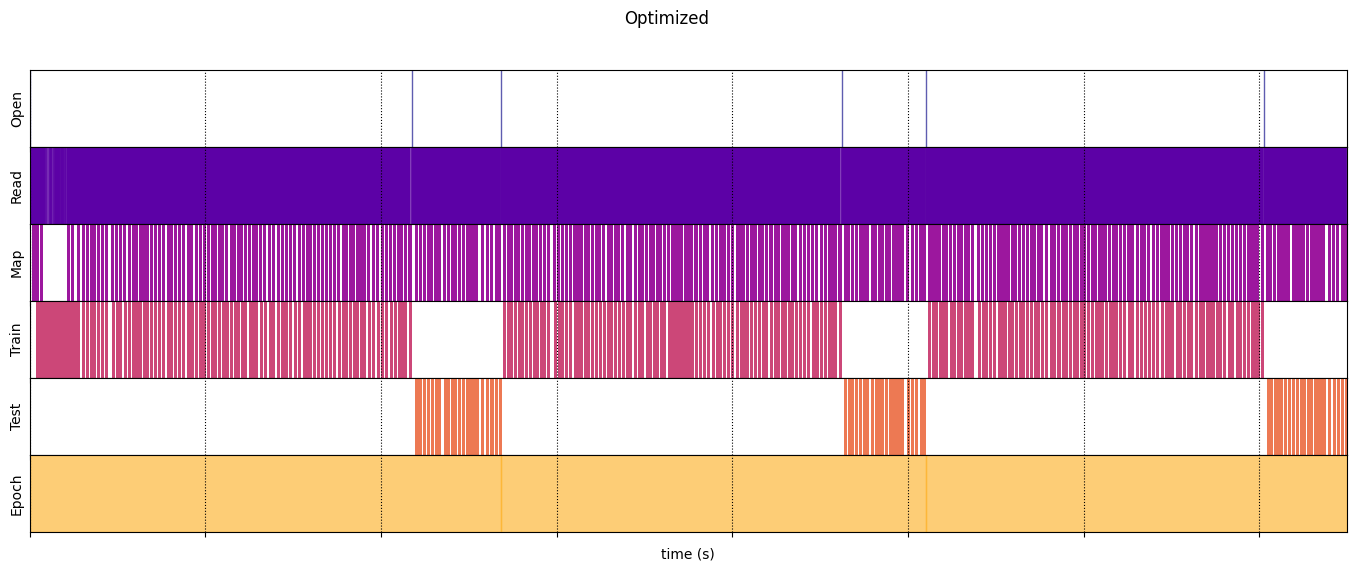

In [ ]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=250)
